In [1]:
# ! unzip -q '/content/drive/MyDrive/Colab Notebooks/Datasets/Landscape color and grayscale images.zip' -d './'

In [1]:
!pip install torch torchvision Pillow matplotlib

In [2]:
!pip install tqdm

In [3]:
# Imports
import os

import torch
import torchvision
from torchvision.io import read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

In [4]:
# Data

MANUAL_SEED = 42
BATCH_SIZE = 32
SHUFFLE = True

In [5]:
# Create dataset to load the images
class LandscapeDataset(Dataset):
    def __init__(self, transform=None):
        self.dataroot = './landscape Images'
        self.images = os.listdir(f'{self.dataroot}/color')
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image Paths
        img_path = self.images[idx]

        # Load the images
        color_img = read_image(f'{self.dataroot}/color/{img_path}') / 255
        gray_img = read_image(f'{self.dataroot}/gray/{img_path}') / 255

        if self.transform:
            color_img = self.transform(color_img)
            gray_img = self.transform(gray_img)

        return color_img, gray_img



In [6]:
transform = transforms.Compose([
    transforms.Resize((150, 150), antialias=False),
])
# Load the dataset
dataset = LandscapeDataset(transform=transform)

# Split the data into train and test data
train_set, test_set = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(MANUAL_SEED))

# Load the train and set data
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

In [7]:
# Visualize some images
def show_images(color, gray):
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    for i in range(5):
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 1].axis('off')
    plt.show()

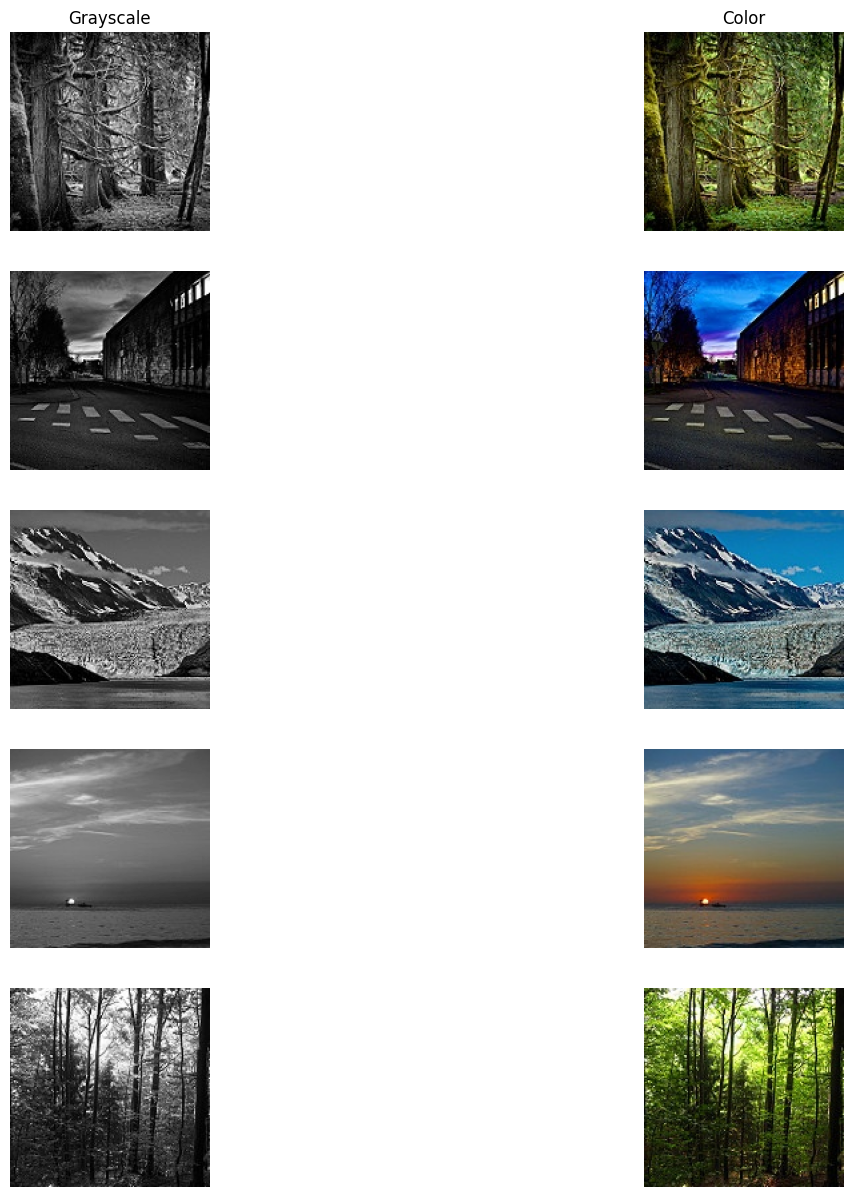

In [8]:
color, gray = next(iter(trainloader))
show_images(color, gray)

In [9]:
# Training Variables

EPOCHS = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.9
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
# # Create the autoencoder model
# class ColorAutoEncoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # Input shape: Bx1x150x150
#         # Conv2d(in_channels, out_channels, kernel_size, stride, padding)


#         self.downsample = nn.Sequential(
#             nn.Conv2d(1, 64, 3, stride=2), # Bx64x74x74
#             nn.ReLU(),

#             nn.Conv2d(64, 128, 3, stride=2), # Bx128x36x36
#             nn.ReLU(),

#             nn.Conv2d(128, 256, 3, stride=2), # Bx256x17x17
#             nn.ReLU(),

#             nn.Conv2d(256, 512, 3, stride=2), # Bx512x8x8
#             nn.ReLU(),
#         )

#         self.upsample = nn.Sequential(
#             nn.ConvTranspose2d(512, 256, 3, stride=2),
#             nn.ReLU(),

#             nn.ConvTranspose2d(256, 128, 3, stride=2,  output_padding=1),
#             nn.ReLU(),

#             nn.ConvTranspose2d(128, 64, 3, stride=2, output_padding=1),
#             nn.ReLU(),

#             nn.ConvTranspose2d(64, 3, 3, stride=2, output_padding=1),
#             nn.ReLU(),

#         )

#     def forward(self, x):
#         x = self.downsample(x)
#         x = self.upsample(x)
#         return x

In [11]:
# Create the autoencoder model
class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Input shape: Bx1x150x150
        # Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        self.down1 = nn.Conv2d(1, 64, 3, stride=2) # Bx64x74x74
        self.down2 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # Bx128x37x37
        self.down3 = nn.Conv2d(128, 256, 3, stride=2, padding=1) # Bx256x19x29
        self.down4 = nn.Conv2d(256, 512, 3, stride=2, padding=1) # Bx512x10x10

        self.up1 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1)
        self.up3 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1)
        self.up4 = nn.ConvTranspose2d(128, 3, 3, stride=2, output_padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Down sample
        d1 = self.relu(self.down1(x))
        d2 = self.relu(self.down2(d1))
        d3 = self.relu(self.down3(d2))
        d4 = self.relu(self.down4(d3))
        # Upsample
        u1 = self.relu(self.up1(d4))
        u2 = self.relu(self.up2(torch.cat((u1,d3), dim=1)))
        u3 = self.relu(self.up3(torch.cat((u2, d2), dim=1)))
        u4 = self.sigmoid(self.up4(torch.cat((u3,d1), dim=1)))

        return u4

In [12]:
# Initialize the model
model = ColorAutoEncoder().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
f"Total Number of trainable parameters of this model are: {total_params:,}"

'Total Number of trainable parameters of this model are: 3,470,659'

In [13]:
# Initialize the optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [14]:
# Define the training loop
for epoch in range(EPOCHS):
    running_loss = 0.0
    for idx, (color_img, gray_img) in tqdm(enumerate(trainloader), total=len(trainloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        # Make model predictions
        predictions = model(gray_img)

        optimizer.zero_grad()
        # Calculate loss between coloured image and predicted image
        loss = criterion(color_img, predictions)

        # Calcuate gradients and back propagate
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch: {epoch + 1}, Loss: {running_loss:.6f}')

print('Training Finished!')

  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 1, Loss: 3.534787


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 2, Loss: 1.844142


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 3, Loss: 1.544257


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 4, Loss: 1.400361


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 5, Loss: 1.336340


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 6, Loss: 1.299495


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 7, Loss: 1.265921


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 8, Loss: 1.245294


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 9, Loss: 1.229997


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 10, Loss: 1.202947
Training Finished!


In [15]:
# Test on testing data
total_loss = 0.0
with torch.no_grad():
    for idx, (color_img, gray_img) in tqdm(enumerate(testloader), total=len(testloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        prediction = model(gray_img)

        loss = criterion(prediction, color_img)
        total_loss += loss.item()

f"Total Testing loss is: {total_loss/ len(testloader):.3f}"

  0%|          | 0/45 [00:00<?, ?it/s]

'Total Testing loss is: 0.007'

In [20]:
# Visualize some predictions
def show_predictions(gray, color, pred):
    fig, axs = plt.subplots(5, 3, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    axs[0, 2].set_title('Predicted')
    for i in range(5):
        axs[i, 0].axis('off')
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 2].axis('off')
        axs[i, 2].imshow(pred[i].permute(1,2,0))
    plt.show()


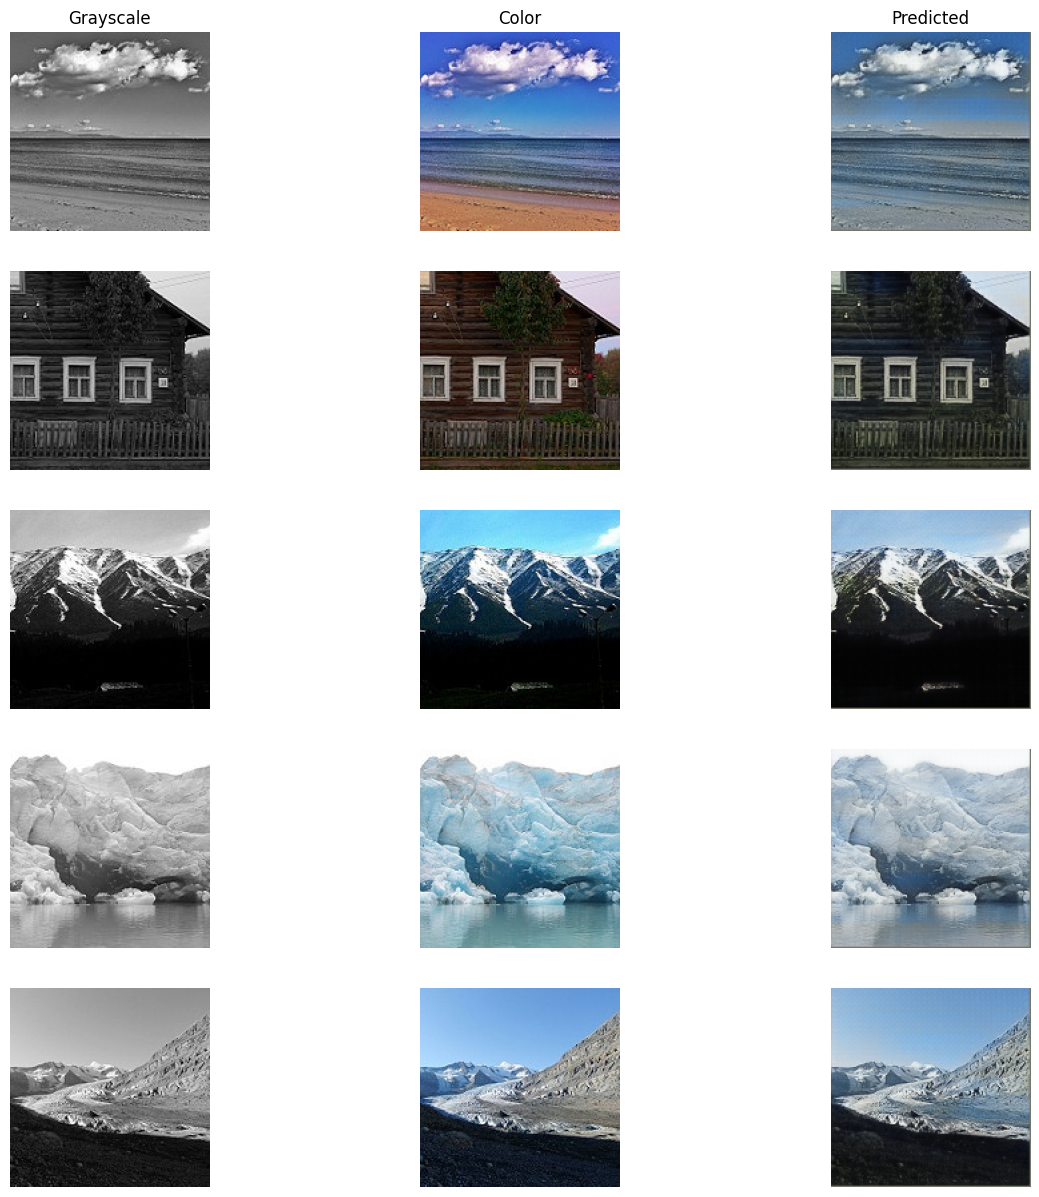

In [22]:
show_predictions(gray_img.detach().cpu(), color_img.detach().cpu(), prediction.detach().cpu())

In [24]:
!pip install opencv-python

  Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl (38.6 MB)


In [31]:
import cv2

img_pred = 'img/plant.webp'
img_pred = cv2.imread(img_pred)
# predicted_img = model(img_pred)

In [29]:
img_pred = cv2.imread(img_pred)
cv2.imshow('predicted image', predicted_img)
cv2.waitKey(0)

-1

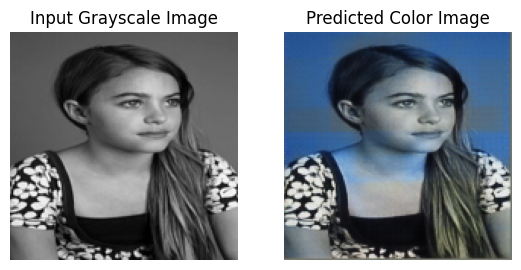

In [49]:
import torch
from torchvision import transforms
from PIL import Image

# Assuming 'model' is your trained autoencoder model

def predict_image(model, input_image_path):
    # Read and preprocess the new image
    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
    ])

    input_image = Image.open(input_image_path).convert('L')  # Convert to grayscale
    input_image = transform(input_image).unsqueeze(0)  # Add batch dimension

    # Move input image to the same device as the model
    device = next(model.parameters()).device
    input_image = input_image.to(device)

    # Make prediction
    with torch.no_grad():
        model.eval()
        predicted_image = model(input_image)

    # Move the predicted image back to CPU for visualization
    predicted_image = predicted_image.cpu()

    return input_image.squeeze(0), predicted_image.squeeze(0)

# Example usage:
input_image_path = 'img\image_6.jpg'
input_image, predicted_image = predict_image(model, input_image_path)

# Visualize the input grayscale image, original color image, and predicted color image
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_image.squeeze().numpy(), cmap='gray')
plt.title('Input Grayscale Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(predicted_image.permute(1, 2, 0).numpy())
plt.title('Predicted Color Image')
plt.axis('off')

plt.show()

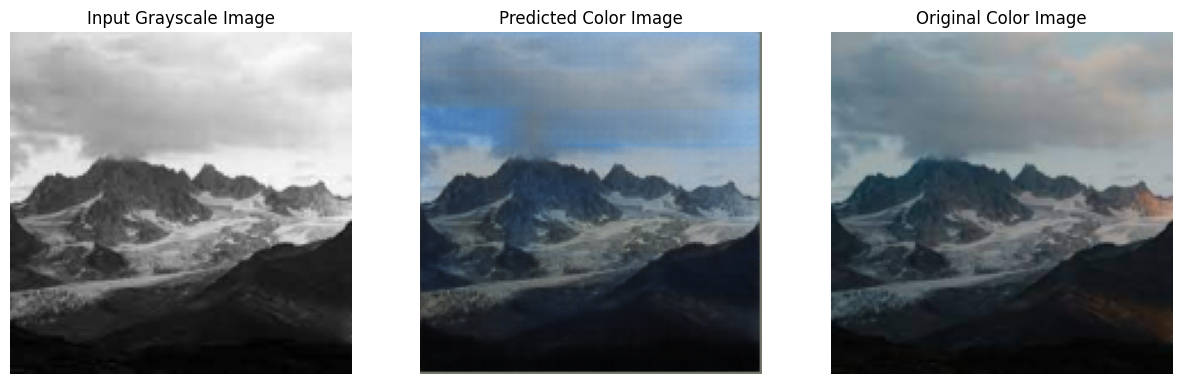

In [61]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Assuming 'model' is your trained autoencoder model

def predict_and_visualize(model, input_gray_path, original_color_path):
    # Read and preprocess the new grayscale image
    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
    ])

    input_gray = Image.open(input_gray_path).convert('L')  # Convert to grayscale
    input_gray = transform(input_gray).unsqueeze(0)  # Add batch dimension
    input_gray = input_gray.to(next(model.parameters()).device)

    # Make prediction
    with torch.no_grad():
        model.eval()
        predicted_color = model(input_gray)

    # Move the predicted color image back to CPU for visualization
    predicted_color = predicted_color.cpu()

    # Read and preprocess the original color image
    original_color = Image.open(original_color_path)
    original_color = transform(original_color).unsqueeze(0)  # Add batch dimension

    # Visualize the images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(input_gray.squeeze().cpu().numpy(), cmap='gray')
    plt.title('Input Grayscale Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_color.squeeze().permute(1, 2, 0).numpy())
    plt.title('Predicted Color Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(original_color.squeeze().permute(1, 2, 0).numpy())
    plt.title('Original Color Image')
    plt.axis('off')

    plt.show()

# Example usage:
input_gray_path = 'img\image_5.jpg'
original_color_path = 'img\image_5_ori.jpg'
predict_and_visualize(model, input_gray_path, original_color_path)
